# Comparing Inference Latency of Models Served with Flask and FastAPI on SageMaker Endpoints

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook.

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-2/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

---

## Background

This notebook will demontrate how the inference latency of the same model varies when one model is served with [Python Flask](https://flask.palletsprojects.com/en/2.3.x/), [FastAPI](https://fastapi.tiangolo.com/) and [SageMaker pre-built container](https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html). In all cases, we use a [decision tree](https://scikit-learn.org/stable/modules/tree.html) algorithm from [scikit-learn](https://scikit-learn.org/stable/) package which is trained on the famous [iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). 

The scripts and this notebook can be used to load test and compare latency for any endpoint that you deploy on SageMaker. You can either test a [pre-built SageMaker container](https://docs.aws.amazon.com/sagemaker/latest/dg/docker-containers-prebuilt.html) or [bring your own container](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-byoc-containers.html). [This GitHub repo](https://github.com/aws/amazon-sagemaker-examples/tree/main/advanced_functionality/scikit_bring_your_own) provides a more detailed example on how to bring your own container to SageMaker

## Permissions

Running this notebook requires `SageMakerFullAccess` permissions. Additionally you will need permissions to publish to Amazon ECR. You can achieve this by adding the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role that you used to start your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

## The experiment

Load testing is carried out on `ml.c5d.18xlarge` SageMaker Notebook Instance type. It is recommended to use a large instance type for load testing in order to be able to provide the adeqate load on the Inference Endpoints

![Diagram](img/diagram.png)

# Part 1: Bundling and Pushing Models to Amazon ECR

There is a script inside each model folder to build and push a model image to ECR. The script logs in to ECR, builds and tags an image and pushes the image to ECR

In [7]:
import concurrent.futures
import subprocess
import re
import os
import pandas as pd

import boto3

from sagemaker import get_execution_role
import sagemaker as sage
from sagemaker.serializers import CSVSerializer
from sagemaker.sklearn.estimator import SKLearn

In [2]:
models = ["flask-model", "fastapi-model"]

In [3]:
!chmod +x ./build_and_push.sh

In [4]:
def build_and_push(model):
    try:
        result = subprocess.run(["./build_and_push.sh", f"{model}"],
                                    capture_output=True, text=True)
        if result.returncode == 0:
            print(f"Successfully built and pushed {model} to Amazon ECR")
        else:
            print(f"Error building and pushing {model}:", result.stderr)
    except Exception as e:
        print("Exception:", str(e))

Below is the script for building and pushing our custom algorithm containers. It looks for an ECR repository in the account you're using and the current default region (if you're using a SageMaker notebook instance, this will be the region where the notebook instance was created). If the repository doesn't exist, the script will create it, build the image and push to the repository

In [6]:
!cat ./build_and_push.sh

#!/usr/bin/env bash

# This script shows how to build the Docker image and push it to ECR to be ready for use
# by SageMaker.

# The argument to this script is the image name. This will be used as the image on the local
# machine and combined with the account and region to form the repository name for ECR.
model=$1

# parent_path=$( cd "$(dirname "${BASH_SOURCE[0]}")" ; pwd -P )

# cd "$parent_path"


if [ "$model" == "" ]
then
    echo "Usage: $0 <model-name>"
    exit 1
fi

# Get the account number associated with the current IAM credentials
account=$(aws sts get-caller-identity --query Account --output text)

if [ $? -ne 0 ]
then
    exit 255
fi


# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}


fullname="${account}.dkr.ecr.${region}.amazonaws.com/${model}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${model}

The cell below executes the scrip and may take a few minutes to run (docker images are building here)

In [5]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for model in models:
        futures.append(executor.submit(build_and_push, model=model))

    for future in concurrent.futures.as_completed(futures):
        print(future.result())

Successfully built and pushed flask-model to Amazon ECR
None
Successfully built and pushed fastapi-model to Amazon ECR
None


# Part 2: Training and Deploying models to SageMaker Inference Endpoints

In [8]:
# S3 prefix
prefix = "sagemaker-endpoint-testing-example"

# Define IAM role
role = get_execution_role()
sess = sage.Session()
account = sess.boto_session.client("sts").get_caller_identity()["Account"]
region = sess.boto_session.region_name

In [9]:
# Define data location
WORK_DIRECTORY = "data"
data_location = sess.upload_data(WORK_DIRECTORY, key_prefix=prefix)

## Train and deploy models in paralled

### Define train and deploy code for custom containers

In [10]:
def train_and_deploy_custom_container_models(endpoint):
    image = f"{account}.dkr.ecr.{region}.amazonaws.com/{endpoint}:latest"
    tree = sage.estimator.Estimator(
        image,
        role,
        1,
        "ml.c4.2xlarge",
        output_path=f"s3://{sess.default_bucket()}/output",
        sagemaker_session=sess,
    )

    tree.fit(data_location)

    tree.deploy(1, "ml.m4.xlarge", serializer=CSVSerializer(),
                endpoint_name=endpoint)

### Define train and deploy code for SageMaker pre-built container

In [11]:
%%writefile script.py

#!/usr/bin/env python

# A sample training component that trains a simple scikit-learn decision tree model.
# This implementation works in File mode and makes no assumptions about the input file names.
# Input is specified as CSV with a data point in each row and the labels in the first column.

from __future__ import print_function

import json
import os
import pickle
import sys
import traceback
import pickle


import pandas as pd
from sklearn import tree

# These are the paths to where SageMaker mounts interesting things in your container.

prefix = '/opt/ml/'

input_path = prefix + 'input/data'
output_path = os.path.join(prefix, 'output')
model_path = os.path.join(prefix, 'model')
param_path = os.path.join(prefix, 'input/config/hyperparameters.json')

# This algorithm has a single channel of input data called 'training'. Since we run in
# File mode, the input files are copied to the directory specified here.
channel_name='training'
training_path = os.path.join(input_path, channel_name)


def model_fn(model_dir):
    #Load Model
    with open(os.path.join(model_dir, "decision-tree-model.pkl"), "rb") as inp:
        clf = pickle.load(inp)
    return clf


# The function to execute the training.
def train():
    print('Starting the training.')
    try:
        # Read in any hyperparameters that the user passed with the training job
        with open(param_path, 'r') as tc:
            trainingParams = json.load(tc)

        # Take the set of files and read them all into a single pandas dataframe
        input_files = [ os.path.join(training_path, file) for file in os.listdir(training_path) ]
        if len(input_files) == 0:
            raise ValueError(('There are no files in {}.\n' +
                              'This usually indicates that the channel ({}) was incorrectly specified,\n' +
                              'the data specification in S3 was incorrectly specified or the role specified\n' +
                              'does not have permission to access the data.').format(training_path, channel_name))
        raw_data = [ pd.read_csv(file, header=None) for file in input_files if file.endswith(".csv")]
        train_data = pd.concat(raw_data)

        # labels are in the first column
        train_y = train_data.iloc[:,0]
        train_X = train_data.iloc[:,1:]

        # Here we only support a single hyperparameter. Note that hyperparameters are always passed in as
        # strings, so we need to do any necessary conversions.
        max_leaf_nodes = trainingParams.get('max_leaf_nodes', None)
        if max_leaf_nodes is not None:
            max_leaf_nodes = int(max_leaf_nodes)

        # Now use scikit-learn's decision tree classifier to train the model.
        clf = tree.DecisionTreeClassifier(max_leaf_nodes=max_leaf_nodes)
        clf = clf.fit(train_X, train_y)
        
        model_dir = os.environ['SM_MODEL_DIR']

        # save the model
        with open(os.path.join(model_dir, 'decision-tree-model.pkl'), 'wb') as out:
            pickle.dump(clf, out)
        print('Training complete.')
    except Exception as e:
        # Write out an error file. This will be returned as the failureReason in the
        # DescribeTrainingJob result.
        trc = traceback.format_exc()
        with open(os.path.join(model_dir, 'failure'), 'w') as s:
            s.write('Exception during training: ' + str(e) + '\n' + trc)
        # Printing this causes the exception to be in the training job logs, as well.
        print('Exception during training: ' + str(e) + '\n' + trc, file=sys.stderr)
        # A non-zero exit code causes the training job to be marked as Failed.
        sys.exit(255)

if __name__ == '__main__':
    train()

    # A zero exit code causes the job to be marked a Succeeded.
    sys.exit(0)

Writing script.py


In [12]:
def train_and_deploy_prebuilt_container_model(model_name):
    FRAMEWORK_VERSION = "0.23-1"

    sklearn_estimator = SKLearn(
        entry_point="script.py",
        role=get_execution_role(),
        instance_count=1,
        instance_type="ml.c5.xlarge",
        framework_version=FRAMEWORK_VERSION,
        base_job_name="sagemaker-scikit-tree",
    )

    sklearn_estimator.fit(data_location)

    sklearn_estimator.deploy(1, "ml.m4.xlarge", serializer=CSVSerializer(),
                endpoint_name=model_name)

## Kick off parallel training and deployment

In [13]:
pre_built_enpoint_name = 'sagemaker-scikit-pre-built'

In [ ]:
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for model in models:
        futures.append(executor.submit(train_and_deploy_custom_container_models, endpoint=model))

    futures.append(executor.submit(train_and_deploy_prebuilt_container_model, model_name=pre_built_enpoint_name))

    for future in concurrent.futures.as_completed(futures):
        print(future.result())

NOTEBOOK_METADATA_FILE detected but failed to get valid domain and user from it.
NOTEBOOK_METADATA_FILE detected but failed to get valid domain and user from it.
INFO:sagemaker:Creating training-job with name: flask-model-2023-11-01-18-39-17-903
INFO:sagemaker:Creating training-job with name: fastapi-model-2023-11-01-18-39-17-902
INFO:sagemaker:Creating training-job with name: sagemaker-scikit-tree-2023-11-01-18-39-18-137


Using provided s3_resource
2023-11-01 18:39:18 Starting - Starting the training job2023-11-01 18:39:18 Starting - Starting the training job..2023-11-01 18:39:20 Starting - Starting the training job.......
2023-11-01 18:39:42 Starting - Preparing the instances for training..
2023-11-01 18:39:36 Starting - Preparing the instances for training.......
2023-11-01 18:39:49 Starting - Preparing the instances for training.........
2023-11-01 18:40:34 Downloading - Downloading input data
2023-11-01 18:40:30 Downloading - Downloading input data..
2023-11-01 18:40:24 Downloading - Downloading input data....Starting the training.
Training complete.
Starting the training.
Training complete.

2023-11-01 18:41:15 Training - Training image download completed. Training in progress.
2023-11-01 18:41:15 Uploading - Uploading generated training model
2023-11-01 18:41:15 Completed - Training job completed

2023-11-01 18:41:11 Training - Training image download completed. Training in progress.
2023-11-01 18

INFO:sagemaker:Creating model with name: fastapi-model-2023-11-01-18-41-29-532
INFO:sagemaker:Creating model with name: flask-model-2023-11-01-18-41-29-565


Training seconds: 42
Billable seconds: 42
Training seconds: 42
Billable seconds: 42


INFO:sagemaker:Creating endpoint-config with name fastapi-model
INFO:sagemaker:Creating endpoint-config with name flask-model
INFO:sagemaker:Creating endpoint with name fastapi-model
INFO:sagemaker:Creating endpoint with name flask-model
INFO:sagemaker:Creating model with name: sagemaker-scikit-tree-2023-11-01-18-41-32-106


Training seconds: 56
Billable seconds: 56


INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-pre-built
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-pre-built


In [21]:
models.append(pre_built_enpoint_name)

# Part 3: Load Testing and Measuring Latency of Each Endpoint

In [22]:
%pip install locust

Note: you may need to restart the kernel to use updated packages.


## Launch

### Locust Configuration

In our experiment, Locust was configured to simulate the behaviour of 200 users, with each user represented by a worker. We ran 30 workers concurrently to generate realistic traffic levels. Each load test point was executed for a duration of 5 minutes, providing sufficient time to capture latency metrics under varying levels of load. 

In [23]:
!cat ./load-testing/run_locust.sh

#!/bin/bash

#replace with your endpoint name in format https://<<endpoint-name>>
export ENDPOINT_NAME=https://$1

export REGION=eu-west-2
export CONTENT_TYPE=text/csv
# export PAYLOAD='{"inputs": "I am super happy right now."}'
export USERS=120
export WORKERS=30
export RUN_TIME=5mg
export LOCUST_UI=false # Use Locust UI

parent_path=$( cd "$(dirname "${BASH_SOURCE[0]}")" ; pwd -P )

cd "$parent_path"

#replace with the locust script that you are testing, this is the locust_script that will be used to make the InvokeEndpoint API calls. 
export SCRIPT=locust_script.py

#make sure you are in a virtual environment
#. ./venv/bin/activate

if $LOCUST_UI ; then
    locust -f $SCRIPT -H $ENDPOINT_NAME --master --expect-workers $WORKERS -u $USERS -t $RUN_TIME --csv results_$1 &
else
    locust -f $SCRIPT -H $ENDPOINT_NAME --master --expect-workers $WORKERS -u $USERS -t $RUN_TIME --csv results_$1 --headless &
fi

for (( c=1; c<=$WORKERS; c++ ))
do 
    locust -f $SCRIPT -H $ENDPOINT_NAME --work

The locust script iteself is then cofigured to hit the SageMaker invoke endpoint API for each request thatis being made by locust

In [24]:
!cat ./load-testing/locust_script.py

import json
import logging
import os
import time

import boto3
from botocore.config import Config
from locust.contrib.fasthttp import FastHttpUser

from locust import task, events

region = os.environ["REGION"]
content_type = os.environ["CONTENT_TYPE"]
# payload = os.environ["PAYLOAD"]

with open("payload.csv", 'r') as f:
    payload = f.read()


class BotoClient:
    def __init__(self, host):
        # Consider removing retry logic to get accurate picture of failure in locust
        config = Config(
            region_name=region, retries={"max_attempts": 0, "mode": "standard"}
        )

        self.sagemaker_client = boto3.client("sagemaker-runtime", config=config)
        self.endpoint_name = host.split("/")[-1]
        self.content_type = content_type
        self.payload = payload

    def send(self):

        request_meta = {
            "request_type": "InvokeEndpoint",
            "name": "SageMaker",
            "start_time": time.time(),
            "response_length": 0,
 

In [26]:
!chmod +x ./load-testing/run_locust.sh

A test for each endpoint takes around 5 minutes to run

In [ ]:
import subprocess

for model in models:
    try:
        result = subprocess.run(
            ["./load-testing/run_locust.sh", f"{model}"], capture_output=True, text=True
        )
        if result.returncode == 0:
            print(f"Finished load testing for {model} endpoint")
        else:
            print(f"Error load testing {model} endpoint:", result.stderr)
    except Exception as e:
        print("Exception:", str(e))

Finished load testing for flask-model endpoint
Finished load testing for fastapi-model endpoint
Finished load testing for sagemaker-scikit-pre-built endpoint


# Part 4: Visualising the results

Locust results are saved in csv files inside the load-testing folder. We load the cvs for each model into pandas and we are specifically interested in min, max and average response times from our endpoints. We build a dictionary with those values and plot a box-plot to visualise the result

INFO:matplotlib.font_manager:generated new fontManager


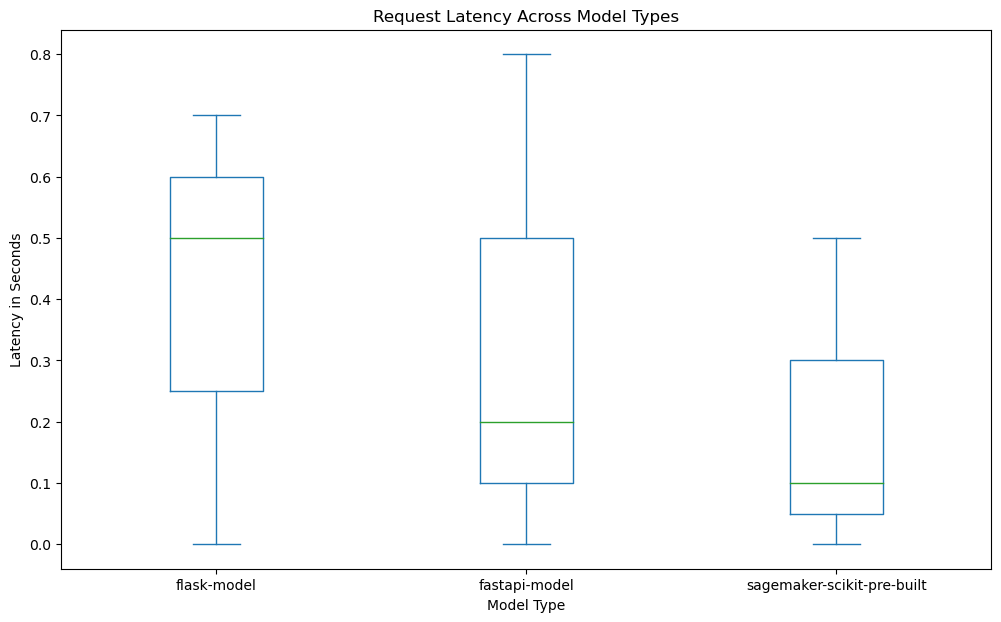

In [28]:
latency_dict = {}

# for each endpoint get latency from the load test results
for model in models:
    df = pd.read_csv(f"./load-testing/results_{model}_stats.csv")

    min_latency = round(df.tail(1)["Min Response Time"].values[0] / 1000, 1)
    avg_latency = round(df.tail(1)["Average Response Time"].values[0] / 1000, 1)
    max_latency = round(df.tail(1)["Max Response Time"].values[0] / 1000, 1)

    latency_dict.update({model: [min_latency, avg_latency, max_latency]})

# generate a data frame of the results and plot a box plot
results = pd.DataFrame(latency_dict)
res_plot = results.plot(
    legend=True,
    figsize=(12, 7),
    kind="box",
    title="Request Latency Across Model Types",
    xlabel="Model Type",
    ylabel="Latency in Seconds",
)

# Part 5: Cleanup Endpoints

In [29]:
sm_client = boto3.client('sagemaker')

In [31]:
for model in models:
    try:
        sm_client.delete_endpoint(
            EndpointName=model
        )
        sm_client.delete_endpoint_config(
            EndpointConfigName=model
        )
    except Exception as e:
        print(f"Error deleting endpoint {model}: {e}")

Error deleting endpoint flask-model: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "flask-model".
Error deleting endpoint fastapi-model: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "fastapi-model".
Error deleting endpoint sagemaker-scikit-pre-built: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "sagemaker-scikit-pre-built".
Error deleting endpoint sagemaker-scikit-pre-built: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "sagemaker-scikit-pre-built".


## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.


![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-1/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-east-2/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/us-west-1/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ca-central-1/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/sa-east-1/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-1/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-2/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-west-3/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-central-1/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/eu-north-1/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-1/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-southeast-2/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-1/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-northeast-2/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://h75twx4l60.execute-api.us-west-2.amazonaws.com/sagemaker-nb/ap-south-1/sagemaker_endpoints_latency_testing|endpoint_testing.ipynb)
